In [35]:
import pandas as pd
moves_df = pd.read_csv("../Data/moves_df.csv", dtype={"fen": str, 'zobrist_key': str})
moves_df.fillna('', inplace=True)

In [150]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797
...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311


In [46]:
from tqdm import tqdm
import chess.engine

In [135]:
import chess
from chess import *

In [143]:
best_move_evals = []
move_evals = []
b = chess.Board()
engine = chess.engine.SimpleEngine.popen_uci("../Stockfish/stockfish_15_x64_avx2")

for i in tqdm(range(30)):
    move = moves_df.iloc[i]['moves']
    move_to_play_on_board = getMove(move)
    
    result = engine.analyse(b, chess.engine.Limit(time=0.5))
    
    best_move = result['pv'][0]
    from_ = best_move.from_square
    to = best_move.to_square
    
    b.push(best_move)
    best_move_eval = position_eval(engine, b, time_limit=0.5)
    best_move_evals.append(best_move_eval)
    b.pop()
    
    b.push(move_to_play_on_board)
    if move_to_play_on_board.from_square == from_ and move_to_play_on_board.to_square == to:
        eval_ = best_move_eval
    else:
        eval_ = position_eval(engine, b, time_limit=0.5)
    move_evals.append(eval_)
    
    
    im_svg = chess.svg.board(b, lastmove=move_to_play_on_board, arrows=[chess.svg.Arrow(from_, to, color="#cc0000cc")])
    outputfile = open('board' + str(i) + '.svg', "w")
    outputfile.write(im_svg)
    outputfile.close()
    
    drawing = svg2rlg('board' + str(i) + '.svg')
    renderPDF.drawToFile(drawing, "file" + str(i) + ".pdf")
    
    inputpath = "./file" + str(i) + ".pdf"
    outputpath = "./"
    # To convert single page
    #result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, pages="1")
    result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, dpi=300, pages="ALL")
    
engine.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:24<00:00,  2.82s/it]


In [144]:
diff = np.array(best_move_evals) - np.array(move_evals)

In [152]:
diff[13]

-15

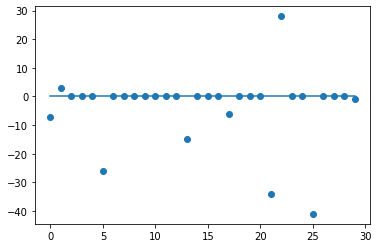

In [154]:
plt.scatter(list(range(30)), diff)
plt.plot([0]*30)

In [77]:
!jt -r

Reset css and font defaults in:
C:\Users\trist\.jupyter\custom &
C:\Users\trist\AppData\Roaming\jupyter\nbextensions


In [1]:
import chess
import chess.svg

In [16]:
b = chess.Board()

In [17]:
im_svg = chess.svg.board(b)

In [18]:
outputfile = open('board.svg', "w")
outputfile.write(im_svg)
outputfile.close()

In [19]:
import svglib

In [25]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

drawing = svg2rlg("board.svg")
renderPDF.drawToFile(drawing, "file.pdf")

In [9]:
from pdf2jpg import pdf2jpg

In [30]:
inputpath = "./file.pdf"
outputpath = "./"
# To convert single page
#result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, pages="1")
result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, dpi=300, pages="ALL")
print(result)

[{'cmd': 'java -jar "C:\\Users\\trist\\anaconda3\\envs\\tf2.6\\Lib\\site-packages\\pdf2jpg\\pdf2jpg.jar" -i "./file.pdf" -o "./" -d 300 -p ALL', 'input_path': './file.pdf', 'output_pdfpath': '.\\file.pdf_dir', 'output_jpgfiles': ['.\\file.pdf_dir\\0_file.pdf.jpg']}]


In [114]:
# functions to evaluate a given chess position

def stockfish_evaluation(engine, board, time_limit = 0.01):
    result = engine.analyse(board, chess.engine.Limit(time=time_limit))
    return result['score'].white()

def position_eval(engine, board, time_limit = 0.01):
    score = stockfish_evaluation(engine, board, time_limit)
    if not score.is_mate():
        return score.score()
    #the engine has found a way to mate in a certain number of moves
    return mateScore(score)

def findNumberOfMovesBeforeMate(score):
    str_nb_moves_before_mate = ''
    s = str(score)
    i = len(s)-1
    while i >= 0 and s[i].isnumeric():
        str_nb_moves_before_mate = s[i] + str_nb_moves_before_mate
        i -= 1
    return int(str_nb_moves_before_mate)

def mateScore(score):
    nb_moves_before_mate = findNumberOfMovesBeforeMate(score)
    white_is_winning = (str(score.wdl())[9] == '1')
    # a.wdl() gives the probability of winning for white
    # if the 9th character is equal to 1, then white will deliver mate shortly
    # otherwise, white will lose soon and black is winning
    score_for_mate = 10000 - nb_moves_before_mate*100
    if not white_is_winning:
        score_for_mate = (-1)*score_for_mate
    return score_for_mate